In [1]:
## Loading the Libaries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PyWRFFun import MonthGlob_multi, CalcStats

# === Get the WRF Values for the entire month and for all 4 locations.
WRFFiles = ["/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP6_RAD1_251126/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP6_RAD3_251127/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP6_RAD4_250718/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL1_FDDA1_MP6_RAD5_251128/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL2_FDDA1_MP8_RAD1_251202/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL2_FDDA1_MP8_RAD3_251201/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL2_FDDA1_MP8_RAD4_250710/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL2_FDDA1_MP8_RAD5_251203/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD1_251120/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD3_251121/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD4_251118/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL5_FDDA1_MP6_RAD5_251119/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL7_FDDA1_MP6_RAD1_251205/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL7_FDDA1_MP6_RAD3_251206/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL7_FDDA1_MP6_RAD4_251206/wrfout_d01_2020-06-*",
            "/data/wto/WRFOUT/Sac_NDown_UCM1_PBL7_FDDA1_MP8_RAD5_251204/wrfout_d01_2020-06-*"]
# The x_labels should be a list of strings
x_labels = [
    "YSU/RRTM","YSU/CAM","YSU/RRTMG","YSU/Goddard",
    "MYJ/RRTM","MYJ/CAM","MYJ/RRTMG","MYJ/Goddard",
    "MYNN2/RRTM","MYNN2/CAM","MYNN2/RRTMG","MYNN2/Goddard",
    "ACM2/RRTM","ACM2/CAM","ACM2/RRTMG","ACM2/Goddard"
]
NModels=len(x_labels)
## Load the EPA Data Input File
WRFLocs= [[38.593322,-121.503795],
          [38.56844,-121.49311],
          [38.613779,-121.368014],
          [37.950741,-121.268523],
          [38.302591,-121.420838],
          [38.443056, -121.858611],
          [38.27556, -121.73667],
          [38.342606,-120.764426],
          [38.890941,-121.003373],
          [38.725282,-120.821916]]
EPA_files = [
    "/data/wto/EPAMetData/hourly_WINDSPD_2020_06_SacWater.csv",
    "/data/wto/EPAMetData/hourly_WINDSPD_2020_06_SacSoCap.csv",
    "/data/wto/EPAMetData/hourly_WINDSPD_2020_06_ArdenArcade.csv",
    "/data/wto/EPAMetData/hourly_WINDSPD_2020_06_Stockton.csv",
    "/data/wto/EPAMetData/hourly_WINDSPD_2020_06_Franklin.csv",
    "/data/wto/EPAMetData/hourly_WINDSPD_2020_06_Dixon.csv",
    "/data/wto/EPAMetData/hourly_WINDSPD_2020_06_MainePrairie.csv",
    "/data/wto/EPAMetData/hourly_WINDSPD_2020_06_Jackson.csv",
    "/data/wto/EPAMetData/hourly_WINDSPD_2020_06_AuburnLake.csv",
    "/data/wto/EPAMetData/hourly_WINDSPD_2020_06_Placerville.csv"
]
NStations=len(EPA_files)
Var = "wspd10" 

NModels   = len(x_labels)
NStations = len(EPA_files)

# Get WRF data for all stations in one go
wrf_station_dfs = MonthGlob_multi(WRFFiles, Var, WRFLocs)
# wrf_station_dfs[istat] : DF with columns Model1..Model16 for that station

MeanBias_all = np.zeros((NStations, NModels))
RMSD_all     = np.zeros((NStations, NModels))
IOA_all      = np.zeros((NStations, NModels))

for istation in range(NStations):
    epa_path = EPA_files[istation]
    print(f"Processing station {istation+1}/{NStations}: {epa_path}")

    # ====== Get the EPA Data ======
    DataDF = pd.read_csv(
        EPA_files[istation],
        header=None, usecols=[11,12,13], names=["date", "time", "OBS"]
    )

    DataDF["datetime"] = pd.to_datetime(DataDF["date"] + " " + DataDF["time"])
    DataDF = DataDF.set_index("datetime").sort_index()
    FullDF = wrf_station_dfs[istation].join(DataDF["OBS"], how="left")

    # Compute stats
    MeanBiases, RMSDs, IOAs = CalcStats(FullDF, Direction=False)

    MeanBias_all[istation, :] = MeanBiases.values
    RMSD_all[istation, :]     = RMSDs.values
    IOA_all[istation, :]      = IOAs.values


Processing station 1/10: /data/wto/EPAMetData/hourly_WINDSPD_2020_06_SacWater.csv
Processing station 2/10: /data/wto/EPAMetData/hourly_WINDSPD_2020_06_SacSoCap.csv
Processing station 3/10: /data/wto/EPAMetData/hourly_WINDSPD_2020_06_ArdenArcade.csv
Processing station 4/10: /data/wto/EPAMetData/hourly_WINDSPD_2020_06_Stockton.csv
Processing station 5/10: /data/wto/EPAMetData/hourly_WINDSPD_2020_06_Franklin.csv
Processing station 6/10: /data/wto/EPAMetData/hourly_WINDSPD_2020_06_Dixon.csv
Processing station 7/10: /data/wto/EPAMetData/hourly_WINDSPD_2020_06_MainePrairie.csv
Processing station 8/10: /data/wto/EPAMetData/hourly_WINDSPD_2020_06_Jackson.csv
Processing station 9/10: /data/wto/EPAMetData/hourly_WINDSPD_2020_06_AuburnLake.csv
Processing station 10/10: /data/wto/EPAMetData/hourly_WINDSPD_2020_06_Placerville.csv


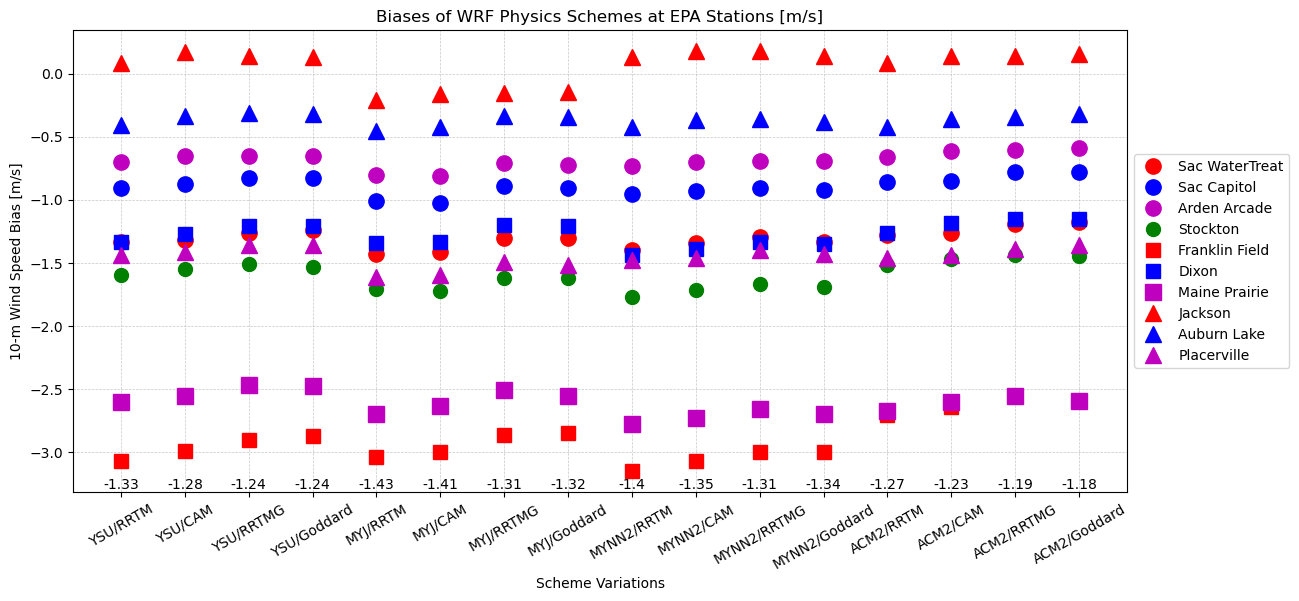

In [4]:
station_labels = [
    "Sac WaterTreat", "Sac Capitol", "Arden Arcade", "Stockton",
    "Franklin Field", "Dixon", "Maine Prairie",
    "Jackson", "Auburn Lake", "Placerville"
]
markercolors = ['or','ob','om','og','sr','sb','sm','^r','^b','^m']

plt.figure(figsize=(17, 6))

# --- Plot each station chunk with your format ---
for s in range(NStations):
    start = s * NModels
    end   = (s+1) * NModels
    plt.plot(
        range(NModels),
        MeanBias_all[s, :],
        markercolors[s],
        ms=11 if s < 3 else 10 if s < 6 else 12,
        label=station_labels[s]
    )

ax = plt.gca()

# --- Move axes left to make space for legend ---
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel("Scheme Variations")
plt.ylabel("10-m Wind Speed Bias [m/s]")
plt.xticks(range(NModels), x_labels, rotation=30)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# --- Add bottom-axis numeric labels (model-mean RMSD) ---
MeanBias_mean = MeanBias_all.mean(axis=0)
for i, val in enumerate(MeanBias_mean):
    ax.text(i, 0.03, f"{val:.3g}", ha='center', va='top',
            transform=ax.get_xaxis_transform())

plt.title("Biases of WRF Physics Schemes at EPA Stations [m/s]")
plt.show()

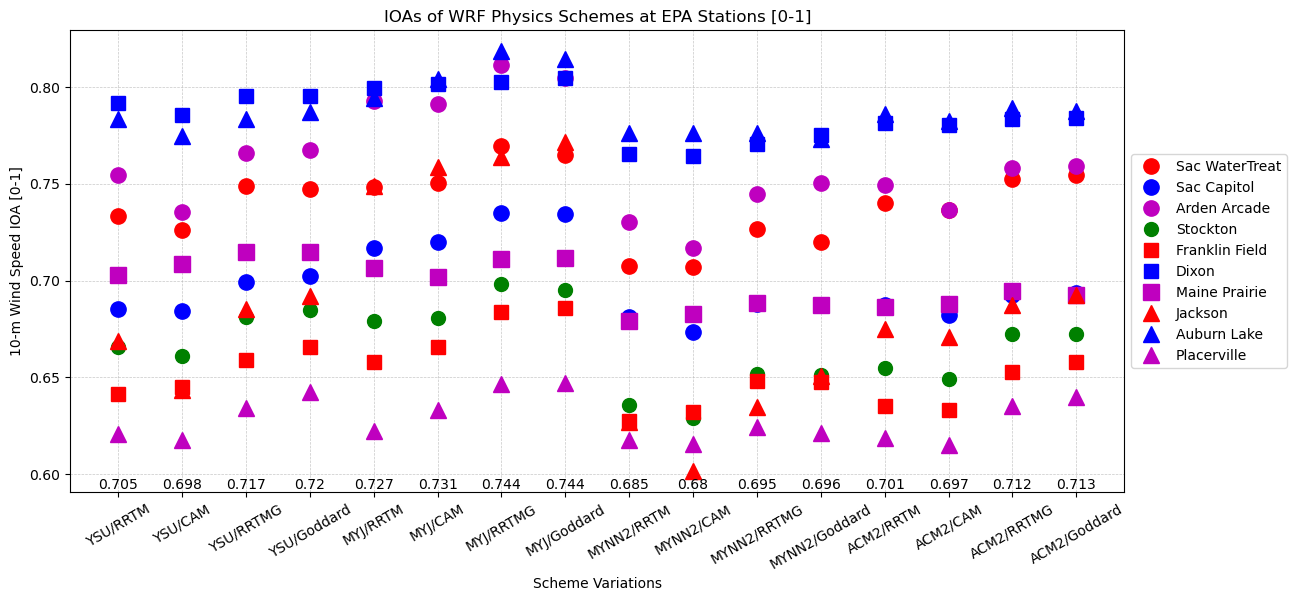

In [5]:
station_labels = [
    "Sac WaterTreat", "Sac Capitol", "Arden Arcade", "Stockton",
    "Franklin Field", "Dixon", "Maine Prairie",
    "Jackson", "Auburn Lake", "Placerville"
]
markercolors = ['or','ob','om','og','sr','sb','sm','^r','^b','^m']

plt.figure(figsize=(17, 6))

# --- Plot each station chunk with your format ---
for s in range(NStations):
    start = s * NModels
    end   = (s+1) * NModels
    plt.plot(
        range(NModels),
        IOA_all[s, :],
        markercolors[s],
        ms=11 if s < 3 else 10 if s < 6 else 12,
        label=station_labels[s]
    )

ax = plt.gca()

# --- Move axes left to make space for legend ---
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel("Scheme Variations")
plt.ylabel("10-m Wind Speed IOA [0-1]")
plt.xticks(range(NModels), x_labels, rotation=30)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# --- Add bottom-axis numeric labels (model-mean RMSD) ---
Mean_IOA = IOA_all.mean(axis=0)
for i, val in enumerate(Mean_IOA):
    ax.text(i, 0.03, f"{val:.3g}", ha='center', va='top',
            transform=ax.get_xaxis_transform())

plt.title("IOAs of WRF Physics Schemes at EPA Stations [0-1]")
plt.show()